In [1]:
from transformers import BertTokenizer

protein_tokenizer = BertTokenizer.from_pretrained("Rostlab/prot_bert", do_lower_case=False)
vocab_size = len(protein_tokenizer.get_vocab().keys())

print(f"load tokenizer\nvocab size: {vocab_size}\nspecial tokens: {protein_tokenizer.all_special_tokens}")

load tokenizer
vocab size: 30
special tokens: ['[UNK]', '[SEP]', '[PAD]', '[CLS]', '[MASK]']


In [2]:
import os
import pickle

if not os.path.exists("data/target/X.pkl"):
    from sklearn.model_selection import train_test_split
    
    with open("data/target/target_sequences.pkl", 'rb') as f:
        data = pickle.load(f)
    
        print(f"load dataset ... # of data: {len(data)}")
    
    X_train, X_test = train_test_split(data, test_size=0.1, random_state=42, shuffle=True)
    X_train, X_valid = train_test_split(X_train, test_size=0.1, random_state=42, shuffle=True)
    
    with open("data/target/X.pkl", "wb") as f:
        pickle.dump([X_train, X_valid, X_test], f)
else:
    with open("data/target/X.pkl", "rb") as f:
        X_train, X_valid, X_test = pickle.load(f)
        
print(f"load dataset\nX_train: {len(X_train)}\nX_valid: {len(X_valid)}\nX_test: {len(X_test)}")

load dataset
X_train: 1636
X_valid: 182
X_test: 203


/home/ubuntu/anaconda3/envs/pytorch/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

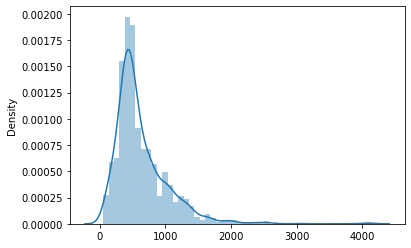

In [3]:
import numpy as np
import seaborn as sns

sns.distplot(np.array([len(x) for x in X_train]))

In [4]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset, RandomSampler
from transformers import DataCollatorForLanguageModeling

max_seq_len = 1000

class MaskedLMDataset(Dataset):
    def __init__(self, data, tokenizer, max_length=1024):
        self.data = data
        self.tokenizer = tokenizer
        self.max_length = max_length
        
        
    def encode(self, data):
        return self.tokenizer.encode(" ".join(data), max_length=self.max_length, truncation=True)
        
        
    def __len__(self):
        return len(self.data)

    
    def __getitem__(self, idx):
        return torch.tensor(self.encode(self.data[idx]), dtype=torch.long)
    
    
data_collator_train = DataCollatorForLanguageModeling(
    tokenizer=protein_tokenizer, mlm=True, mlm_probability=0.3
)

data_collator_valid = DataCollatorForLanguageModeling(
    tokenizer=protein_tokenizer, mlm=True, mlm_probability=0.15
)

train_dataset = MaskedLMDataset(X_train, protein_tokenizer, max_length=max_seq_len)
train_dataloader = DataLoader(train_dataset, batch_size=6, collate_fn=data_collator_train, 
                              num_workers=3, pin_memory=False, prefetch_factor=4, 
                              shuffle=True)

valid_dataset = MaskedLMDataset(X_valid, protein_tokenizer, max_length=max_seq_len)
valid_dataloader = DataLoader(valid_dataset, batch_size=6, collate_fn=data_collator_valid, 
                              num_workers=3, pin_memory=False, prefetch_factor=4)

test_dataset = MaskedLMDataset(X_test, protein_tokenizer, max_length=max_seq_len)
test_dataloader = DataLoader(test_dataset, batch_size=6, collate_fn=data_collator_valid, 
                             num_workers=3, pin_memory=False, prefetch_factor=4)


In [5]:
import torchmetrics
import torchmetrics.functional as FM
import pytorch_lightning as pl
from transformers import BertForMaskedLM
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping


class Bert(pl.LightningModule):
    def __init__(self):
        super().__init__()
        self.model = BertForMaskedLM.from_pretrained("Rostlab/prot_bert")
        for param in self.model.base_model.encoder.layer[0:-1].parameters():
            param.requires_grad = False
        
    def forward(self, input_ids, labels):
        return self.model(input_ids=input_ids, labels=labels)

       
    def training_step(self, batch, batch_idx):
        input_ids = batch['input_ids']
        labels = batch['labels']
        
        output = self(input_ids, labels)

        loss = output.loss
        logits = output.logits

        preds = logits.argmax(dim=-1)
        
        self.log('train_loss', float(loss), on_step=True, on_epoch=True, prog_bar=True)
        self.log("train_accuracy", FM.accuracy(preds[labels > 0], labels[labels > 0]), on_step=False, on_epoch=True, prog_bar=True, logger=True)
        
        return loss

    
    def validation_step(self, batch, batch_idx):
        input_ids = batch['input_ids']
        labels = batch['labels']
        
        output = self(input_ids, labels)

        loss = output.loss
        logits = output.logits

        preds = logits.argmax(dim=-1)
        
        self.log('valid_loss', float(loss), on_step=False, on_epoch=True, prog_bar=True)
        self.log("valid_accuracy", FM.accuracy(preds[labels > 0], labels[labels > 0]), on_step=False, on_epoch=True, prog_bar=True, logger=True)
    
    
    def test_step(self, batch, batch_idx):
        input_ids = batch['input_ids']
        labels = batch['labels']
        
        output = self(input_ids, labels)

        loss = output.loss
        logits = output.logits

        preds = logits.argmax(dim=-1)
        
        self.log('test_loss', float(loss), on_step=False, on_epoch=True, prog_bar=True)
        self.log("test_accuracy", FM.accuracy(preds[labels > 0], labels[labels > 0]), on_step=False, on_epoch=True, prog_bar=True, logger=True)
    
    
    def configure_optimizers(self):
        optimizer = torch.optim.AdamW(self.parameters(), lr=1e-4)
        scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=5)
    
        return {"optimizer": optimizer, "lr_scheduler": scheduler}
    
    
model = Bert()
callbacks = [
    ModelCheckpoint(monitor='valid_loss', save_top_k=10, dirpath='weights/protein_bert_pretraining_masking_rate_30', filename='protein_bert-{epoch:03d}-{valid_loss:.4f}-{valid_accuracy:.4f}'),
]

trainer = pl.Trainer(max_epochs=50, gpus=1, enable_progress_bar=True, callbacks=callbacks)

Some weights of the model checkpoint at Rostlab/prot_bert were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


In [6]:
trainer.fit(model, train_dataloader, valid_dataloader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type            | Params
------------------------------------------
0 | model | BertForMaskedLM | 419 M 
------------------------------------------
54.6 M    Trainable params
365 M     Non-trainable params
419 M     Total params
1,679.733 Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

In [7]:
# without finetuning
# trainer.test(model, test_dataloader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/ubuntu/anaconda3/envs/pytorch/lib/python3.8/site-packages/pytorch_lightning/trainer/data_loading.py:116: UserWarning: The dataloader, test_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Testing: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_accuracy': 0.7976479530334473, 'test_loss': 0.6685153841972351}
--------------------------------------------------------------------------------


[{'test_loss': 0.6685153841972351, 'test_accuracy': 0.7976479530334473}]

In [7]:
# with finetuning
ckpt_fname = "protein_bert-epoch=043-valid_loss=0.5893-valid_accuracy=0.8369.ckpt"
model = Bert().load_from_checkpoint("weights/protein_bert_pretraining_masking_rate_30/" + ckpt_fname)

trainer.test(model, test_dataloader)

Some weights of the model checkpoint at Rostlab/prot_bert were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at Rostlab/prot_bert were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model

Testing: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_accuracy': 0.8568375110626221, 'test_loss': 0.5093826055526733}
--------------------------------------------------------------------------------


[{'test_loss': 0.5093826055526733, 'test_accuracy': 0.8568375110626221}]

In [8]:
model.model.base_model.save_pretrained("weights/protein_bert")